In [1]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets
from torch import nn
import wandb
from PIL import Image
import random
import pandas as pd
import numpy as np
import os
import torchaudio
import tqdm
import librosa
from torchaudio import transforms
from torch.utils.data import DataLoader, Dataset,TensorDataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, accuracy_score
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import f1_score

/home/gustavo/anaconda3/envs/rnp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn
import random

In [3]:
# Get cpu, gpu or mps device for training.
DEVICE = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {DEVICE} device")

NUM_WORKERS = 4

Using cuda device


In [4]:
class game_model():
    def __init__(self, n, pieces):
        self.n = n
        self.pieces = pieces
        self.matriz = np.full((n,n),-20,dtype=int)
        self.reward_matriz = np.full((n,n), 0.5)
    
    def reset_matrix(self):
        self.matriz = np.full((self.n,self.n),-20,dtype=int)
        self.reward_matriz = np.full((self.n,self.n), 0.5)

    def print_matrix(self):
        for i in range(0,self.n):
            print(self.matriz[i][:], ' --- ', self.reward_matriz[i][:])


    def print_reward(self):
        for i in range(0,self.n):
            print(self.reward_matriz[i][:])

    def print_game(self):
        matriz = self.matriz
        for i in range(0,100):
            print()
        substituicoes = {5: "X", 7: "O", -20:'0'}
        for linha in matriz:
            linha_formatada = [str(substituicoes.get(valor, valor)) for valor in linha]
            print(" | ".join(linha_formatada))
            print("-" * 9)

    def get_reward_number(self):
        return np.argmax(self.reward_matriz)
    

    
    
    def calc_reward_matrix(self,piece):
        reward_matriz = np.zeros(shape=(self.n,self.n))

        for i in range(0,self.n):
            alpha  = 0.4
            beta = 0.4
            omega = 0.2

            values_row,counts_row = np.unique(self.matriz[i,:], return_counts=True)
            index_piece = np.where(values_row==piece)
            index_other = np.where((values_row!=piece) & (values_row!=-20))
            index_0 = np.where(values_row==-20)

            values_col,counts_col = np.unique(self.matriz[:,i], return_counts=True)
            index_piece_col = np.where(values_col==piece)
            index_other_col = np.where((values_col!=piece) & (values_col!=-20))
            index_0_col = np.where(values_col==-20)


            rows = np.sum(counts_row[index_piece])*alpha+(-np.sum(counts_row[index_other])*omega)**2 + index_0[0].shape[0]*beta
            cols = np.sum(counts_col[index_piece_col])*alpha+(-np.sum(counts_col[index_other_col])*omega)**2 + index_0_col[0].shape[0]*beta
            reward = rows+cols
            reward_matriz[i,np.where(self.matriz[i,:]==-20)] = reward
        
        self.reward_matriz = reward_matriz

    def number_ij(self, number):
        i = number//self.n
        j = number % self.n
        return i,j
    
    def ji_number(self, i, j):
        number = i * self.n + j
        return number
    
    def get_random_move(self):
        possible_move_i, possible_move_j = np.where(self.matriz == -20)
        
        if possible_move_j.shape[0] > 0:  # Verifica se há movimentos possíveis
            index = random.randint(0, possible_move_j.shape[0] - 1)  # Correção aqui
        else:
           pass
        return possible_move_i[index], possible_move_j[index]

    def move(self,index_i,index_j,piece):
        if piece in self.pieces:
            if self.matriz[index_i][index_j] == -20:
                self.matriz[index_i][index_j] = piece
            else:
                pass
        else:
            #print('Jogada não disponivel')
            pass
    

            
    def check_win(self, piece_p, piece_x):
        state = False
        win_piece = -1
        value_counts_diagonal = np.unique(self.matriz.diagonal())
        value_counts_diagonal2  = np.unique(np.fliplr(self.matriz).diagonal())
        if value_counts_diagonal.shape[0] == 1 and value_counts_diagonal[0] !=-20:
            state=True     
            win_piece = value_counts_diagonal[0]           
        if value_counts_diagonal2.shape[0] == 1 and value_counts_diagonal2[0] !=-20:
            state=True    
            win_piece = value_counts_diagonal2[0]            

        for i in range(0,self.n):
            value_counts_linha = np.unique(self.matriz[i,:])
            value_counts_coluna = np.unique(self.matriz[:,i])
            
            if value_counts_linha.shape[0] == 1 and value_counts_linha[0] != -20 :
                state=True
                win_piece = value_counts_linha[0]
                break
            if value_counts_coluna.shape[0] == 1 and value_counts_coluna[0] != -20:
                state=True
                win_piece = value_counts_coluna[0]
                break
        velha = np.where(self.matriz == -20)
        
        if state:
            if win_piece == piece_p: 
                return piece_p
            else:
                return piece_x
        if velha[0].shape[0] == 0: 
            return 0      



In [5]:
class Evaluator:
    '''
    [EN] Evaluator class for loss function
    [PT-BR] Classe de Evaluator do modelo para função de custo
    '''
    def __init__(self):
        self.loss_fn = nn.CrossEntropyLoss()

    def get_loss(self, y, y_hat):
        return self.loss_fn(y_hat, y)
    

# Define model
class NeuralNetwork(nn.Module):
    
    def __init__(self):
        super().__init__() 
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(9, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32,24),
            nn.ReLU(),
            nn.Linear(24,24),
            nn.ReLU(),
            nn.Linear(24, 16),
            nn.ReLU(),
            nn.Linear(16, 9)
        )

    def forward(self, x):

        x = self.linear_relu_stack(x)
        return x

   
    
class Learner:
    '''
    [EN]Defining the optimizer of model, Adam is used for faster convergence
    [PT-BR]Definindo um otimizadar para o modelo, o Adam é usado para ter uma convergência mais rápida
    '''
    def __init__(self):
        self.model = NeuralNetwork()
        self.model.to(DEVICE)
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=3e-6)

    def predict(self, x):
        return self.model(x)

    def update(self, loss):
        # Backpropagation
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [6]:
class Trainer:
    def __init__(self, learner: Learner, evaluator: Evaluator, game: game_model):
        self.learner = learner
        self.evaluator = evaluator
        self.game = game
       
    
    def play_one_game(self, training):
        game_over = False
        correct =0
        while not game_over:
            
            self.learner.model.train(training)

            # Obter estado do jogo
            X = torch.from_numpy(self.game.matriz).flatten().view(-1).to(torch.float32)
            self.game.calc_reward_matrix(piece=5)

            reward_matriz = torch.from_numpy(self.game.reward_matriz).flatten().view(-1).to(torch.float32).to(DEVICE)
            # Calcular recompensa
            X, reward_matriz = X.to(DEVICE), reward_matriz.to(DEVICE)

            # Fazer a previsão da jogada
            y_hat = self.learner.predict(X)
            y_pred = y_hat.argmax(0).item()

            loss = self.evaluator.get_loss(reward_matriz, y_hat)
            if training:

                self.learner.update(loss)
                loss = loss.item()
                correct += (y_hat.argmax(0).item() == self.game.get_reward_number())

            # Verificar se o jogo terminou
            

            # Realizar a jogada da IA
            i, j = self.game.number_ij(y_pred)
            self.game.move(i, j, 5)
            w5 = self.game.check_win(5,7)
            if w5 == 5 or w5 == 7 or w5 == 0:
                self.game.reset_matrix()
                return loss, correct,w5
            # Realizar uma jogada aleatória
            i, j = self.game.get_random_move()
            self.game.move(i, j, 7)
        
    def play_one_game_iaxia(self, training):
        game_over = False
        correct =0
        while not game_over:
            self.learner.model.train(training)
            X = torch.from_numpy(self.game.matriz).flatten().view(-1).to(torch.float32)
            self.game.calc_reward_matrix(piece=5)
            reward_matriz = torch.from_numpy(self.game.reward_matriz).flatten().view(-1).to(torch.float32).to(DEVICE)
            X, reward_matriz = X.to(DEVICE), reward_matriz.to(DEVICE)
            # Fazer a previsão da jogada
            y_hat = self.learner.predict(X)
            y_pred = y_hat.argmax(0).item()
            loss = self.evaluator.get_loss(reward_matriz, y_hat)
            if training:
                self.learner.update(loss)
                loss = loss.item()
                correct += (y_hat.argmax(0).item() == self.game.get_reward_number())
            
            # Realizar a jogada da IA 5 
            i, j = self.game.number_ij(y_pred)
            self.game.move(i, j, 5)
            w5 = self.game.check_win(5,7)
            if w5 == 5 or w5 == 7 or w5 == 0:
                self.game.reset_matrix()
                return loss, correct,w5

            X = torch.from_numpy(self.game.matriz).flatten().view(-1).to(torch.float32)
            self.game.calc_reward_matrix(piece=7)
            reward_matriz = torch.from_numpy(self.game.reward_matriz).flatten().view(-1).to(torch.float32).to(DEVICE)
            X, reward_matriz = X.to(DEVICE), reward_matriz.to(DEVICE)
            # Fazer a previsão da jogada
            y_hat = self.learner.predict(X)
            y_pred = y_hat.argmax(0).item()
            loss = self.evaluator.get_loss(reward_matriz, y_hat)
            if training:
                self.learner.update(loss)
                loss = loss.item()
                correct += (y_hat.argmax(0).item() == self.game.get_reward_number())
            
            # Realizar a jogada da IA 7 
            i, j = self.game.number_ij(y_pred)
            self.game.move(i, j, 7)
            w7 = self.game.check_win(7,5)
            if w7 == 5 or w7 == 7 or w7 == 0:
                self.game.reset_matrix()
                return loss, correct,w7

            self.game.move(i, j, 7)
            


    def run(self, n_epochs: int):
        wandb.init(project="RL-tictactoe", entity="gustavoreis")
        w,l,x = 1,1,1
        wins = []
        losses  = []
        draws = []
        games = []
        for i in tqdm.tqdm(range(0,n_epochs)):
            loss,correct,w5 = self.play_one_game(True)
            if w5 == 5:
                w+=1
                
            elif w5 == 7:
                l+=1
            else:
                x+=1
            wins.append(w)
            draws.append(x)
            losses.append(l)
            wandb.log({"Loss/train per game": loss, "Correct plays per game": correct, 
                       "Game wins": n_epochs-w, "Game losses":n_epochs-l, "Draw":n_epochs-x})
        return wins,losses,draws, games
        
    def play_vs_human(self):
        game_over = False
        self.game.reset_matrix()
        human = random.choice([5, 7])
        ai = 5 if human == 7 else 7
        with torch.no_grad():
            while not game_over:
                if ai == 5:
                    X = torch.from_numpy(self.game.matriz).flatten().view(-1).to(torch.float32)
                    self.game.calc_reward_matrix(piece=ai)
                    reward_matriz = torch.from_numpy(self.game.reward_matriz).flatten().view(-1).to(torch.float32).to(DEVICE)
                    X, reward_matriz = X.to(DEVICE), reward_matriz.to(DEVICE)
                    y_hat = self.learner.predict(X)
                    y_pred = y_hat.argmax(0).item()
                    i, j = self.game.number_ij(y_pred)
                    w5 = self.game.check_win(5,7)
                    if w5 == 5 or w5 == 7 or w5 == 0:
                        print(f"wins {w5}")
                        break
                    print("AI move:")
                    self.game.move(i, j, ai)
                    if w5 == 5 or w5 == 7 or w5 == 0:
                        print(f"wins {w5}")
                        break
                    print()
                    self.game.print_game()
                    print()
                    print("Human move")
                    human_input = int(input())
                    i,j = self.game.number_ij(human_input)
                    self.game.move(i,j,human)

                    print()
                    self.game.print_game()
                    print()
                else:
                    print("Human move")
                    human_input = int(input())
                    i,j = self.game.number_ij(human_input)
                    self.game.move(i,j,human)
                    w5 = self.game.check_win(5,7)
                    if w5 == 5 or w5 == 7 or w5 == 0:
                        print(f"wins {w5}")
                        break

                    print()
                    self.game.print_game()
                    print()

                    X = torch.from_numpy(self.game.matriz).flatten().view(-1).to(torch.float32)
                    self.game.calc_reward_matrix(piece=ai)
                    reward_matriz = torch.from_numpy(self.game.reward_matriz).flatten().view(-1).to(torch.float32).to(DEVICE)
                    X, reward_matriz = X.to(DEVICE), reward_matriz.to(DEVICE)
                    y_hat = self.learner.predict(X)
                    y_pred = y_hat.argmax(0).item()
                    i, j = self.game.number_ij(y_pred)
                    w5 = self.game.check_win(5,7)
                    if w5 == 5 or w5 == 7 or w5 == 0:
                        print(f"wins {w5}")
                        break
                    print("AI move:")
                    self.game.move(i, j, ai)
                    print()
                    self.game.print_game()
                    print()
               





    def run_iaxia(self, n_epochs: int):
        games = []
        w,l,x = 1,1,1
        wins = []
        losses  = []
        draws = []
        games = []
        for i in tqdm.tqdm(range(0,n_epochs)):
            loss,correct,w5 = self.play_one_game_iaxia(True)
            if w5 == 5:
                w+=1
                
            elif w5 == 7:
                l+=1
            else:
                x+=1
            wins.append(w)
            draws.append(x)
            losses.append(l)
            games.append(w5)

        wandb.log({"Loss/train ia vs ia": loss,  
                    "Game 5 wins": w, "Game 7 wins":l, "Draw ia x ia":x})
        return wins,losses,draws, games

In [7]:
lean = Learner()
evalu = Evaluator()
tab  =game_model(n=3,pieces=[5,7])

tr = Trainer(learner=lean, evaluator=evalu, game=tab)
w,l,x, games = tr.run(10000)
w,l,x, games = tr.run_iaxia(30000)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: gustavoreis. Use `wandb login --relogin` to force relogin


100%|██████████| 30000/30000 [31:48<00:00, 15.72it/s]  


In [10]:
tr.play_vs_human()

AI move:





































































































0 | X | 0
---------
0 | 0 | 0
---------
0 | 0 | 0
---------

Human move







































































































0 | X | 0
---------
0 | 0 | 0
---------
0 | O | 0
---------

AI move:





































































































0 | X | 0
---------
0 | X | 0
---------
0 | O | 0
---------

Human move





































































































0 | X | 0
---------
0 | X | 0
---------
0 | O | 0
---------

AI move:





































































































0 | X | 0
---------
X | X | 0
---------
0 | O | 0
---------

Human move





































































































0 | X | O
---------
X | X | 0
---------
0 | O | 0
---------

AI move:





































































































X | X | O
---------
X | X | 0
---------


In [9]:
games_numpy = np.array(games)
len_g = games_numpy.shape[0]
wins_5 = np.where(games_numpy == 5)[0].shape[0]
wins_7 = np.where(games_numpy == 7)[0].shape[0]
draws = np.where(games_numpy == 0)[0].shape[0]

print(f"Wins 5: [{wins_5}/{len_g}] \n",
      f"Wins 7: [{wins_7}/{len_g}] \n",
      f"Draws: [{draws}/{len_g}] \n"
      f"Wins x draws [{wins_5+wins_7}/{draws}]")

Wins 5: [21091/30000] 
 Wins 7: [5151/30000] 
 Draws: [3758/30000] 
Wins x draws [26242/3758]


In [ ]:
wins_7

11238

In [ ]:
draws

4823

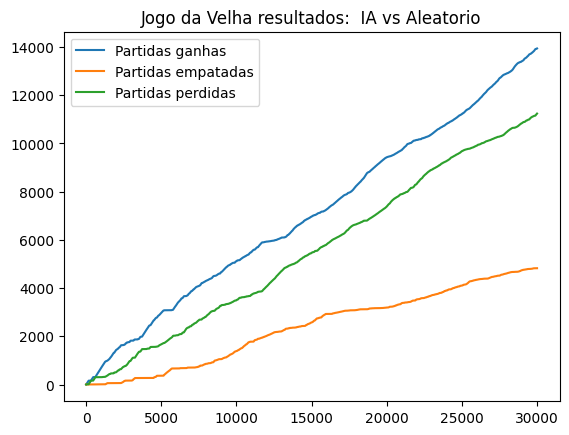

In [ ]:
plt.title('Jogo da Velha resultados:  IA vs Aleatorio')
plt.plot(w, label='Partidas ganhas')
plt.plot(x, label='Partidas empatadas')
plt.plot(l,label='Partidas perdidas')
plt.legend()